In [1]:
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import cmocean
import dask.distributed as dsk
import matplotlib.gridspec as gs
import matplotlib.path as mpath
import matplotlib.pyplot as plt
import numpy as np
import xarray as xr
from cartopy.util import add_cyclic_point

import warnings # ignore these warnings
warnings.filterwarnings("ignore", category = FutureWarning)
warnings.filterwarnings("ignore", category = UserWarning)
warnings.filterwarnings("ignore", category = RuntimeWarning)

clnt = dsk.Client()
clnt

Client Scheduler: tcp://127.0.0.1:36035 Dashboard: /proxy/34357/status,Cluster Workers: 7 Cores: 28 Memory: 250.00 GiB


In [2]:
theta = np.linspace(0, 2*np.pi, 100)
center, radius = [0.5, 0.5], 0.5
verts = np.vstack([np.sin(theta), np.cos(theta)]).T
circle = mpath.Path(verts * radius + center)
iso = xr.open_dataset('~/g_e14/misc/Antarctic_isobath_1000m.nc')

# Load datasets

In [66]:
uas = {}
vas = {}
uas['ERAI'] = xr.open_dataset('../data/uas-erai-monthly-1979_2015.nc')['uas'].sel(lat = slice(None, -50)).sel(time = slice('1979-01-01', '2015-01-01'))
vas['ERAI'] = xr.open_dataset('../data/vas-erai-monthly-1979_2015.nc')['vas'].sel(lat = slice(None, -50)).sel(time = slice('1979-01-01', '2015-01-01'))
uas['CFSR'] = xr.open_dataset('../data/uas-cfsr-monthly-1979_2015.nc')['ua'].sel(lat = slice(None, -50))
vas['CFSR'] = xr.open_dataset('../data/vas-cfsr-monthly-1979_2015.nc')['va'].sel(lat = slice(None, -50))
uas['JRA5'] = xr.open_dataset('../data/uas-jra55-monthly-1979_2015.nc')['uas'].sel(lat = slice(None, -50)).sel(time = slice('1979-01-01', '2015-01-01'))
vas['JRA5'] = xr.open_dataset('../data/vas-jra55-monthly-1979_2015.nc')['vas'].sel(lat = slice(None, -50)).sel(time = slice('1979-01-01', '2015-01-01'))
uas['CMIP'] = xr.open_dataset('../data/uas-cmip6-monthly-1958_2015.nc')['uas'].sel(time = slice('1979-01-01', '2015-01-01'))
vas['CMIP'] = xr.open_dataset('../data/vas-cmip6-monthly-1958_2015.nc')['vas'].sel(time = slice('1979-01-01', '2015-01-01'))

In [4]:
mask = xr.open_dataset('../data/zero_div_line_with_wap_mask.nc')['__xarray_dataarray_variable__']

In [17]:
hu = xr.open_dataset('~/g_e14/misc/hu-01deg.nc')['hu'].sel(yu_ocean = slice(None, -50))
land_ice_mask = xr.where(np.isnan(hu.interp(yu_ocean = np.arange(-90, -50.1, .1))), 1, np.nan).interp(yu_ocean = np.arange(-90, -50.1, .1))

# Mean 1979 - 2015

In [67]:
wsp = {}
for k in ['ERAI', 'CFSR', 'JRA5', 'CMIP']:
    wsp[k] = np.sqrt(uas[k].mean('time')**2 + vas[k].mean('time')**2)

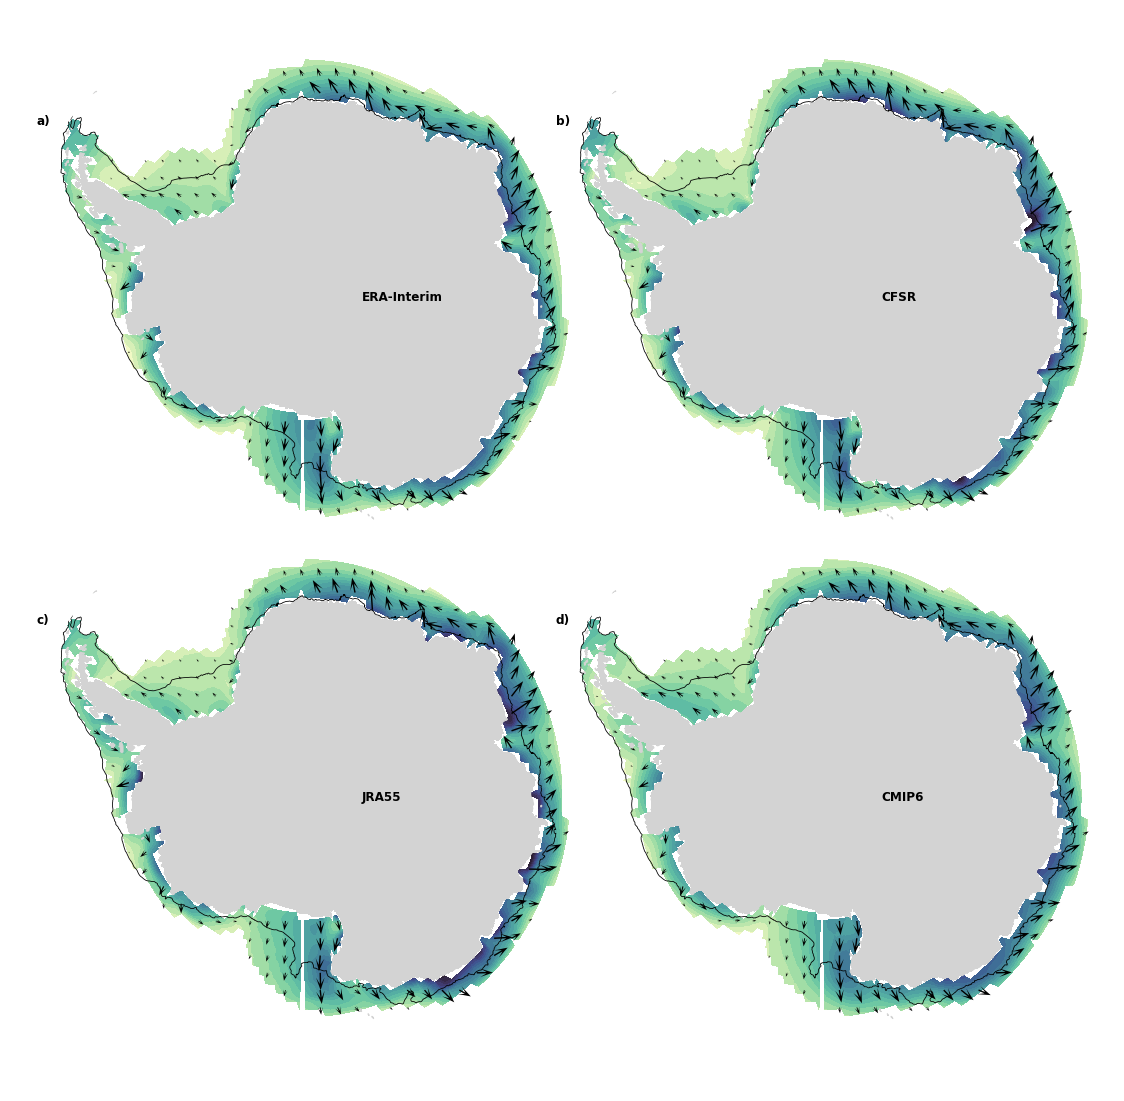

In [68]:
fig = plt.figure(figsize = (20, 20))
gr = gs.GridSpec(2, 2, figure = fig, wspace = -0.13, hspace = -0.15)
axs = [fig.add_subplot(gr[0,0], projection = ccrs.SouthPolarStereo()),
       fig.add_subplot(gr[0,1], projection = ccrs.SouthPolarStereo()),
       fig.add_subplot(gr[1,0], projection = ccrs.SouthPolarStereo()),
       fig.add_subplot(gr[1,1], projection = ccrs.SouthPolarStereo())]
for ax, lb in zip(axs, ['a)', 'b)', 'c)', 'd)']):
    ax.set_extent([-180, 180, -90, -60], ccrs.PlateCarree())
    ax.add_feature(cfeature.NaturalEarthFeature('physical', 'land', '50m', edgecolor = 'lightgrey', facecolor = 'lightgrey'), zorder = 2)
    ax.spines['geo'].set_edgecolor(None)
    ax.text(0.05, .8, lb, transform=ax.transAxes, size = 12, weight='bold')
    ax.patch.set_alpha(0)
    ax.set_boundary(circle, transform = ax.transAxes)
    ax.contourf(land_ice_mask['xu_ocean'], land_ice_mask['yu_ocean'], land_ice_mask, colors = ['lightgrey'], 
                transform = ccrs.PlateCarree())
n = 0
for k, lb in zip(['ERAI', 'CFSR', 'JRA5', 'CMIP'], ['ERA-Interim', 'CFSR', 'JRA55', 'CMIP6']):
    
    u = uas[k].mean('time')*mask; v = vas[k].mean('time')*mask
    
    axs[n].contourf(wsp[k]['lon'], wsp[k]['lat'], wsp[k]*mask, levels = np.arange(0, 10.5, .5), cmap = cmocean.cm.deep,
                    transform = ccrs.PlateCarree())
    axs[n].plot(iso['x'], iso['y'], linewidth = 0.8, color = 'k', transform = ccrs.PlateCarree())
    axs[n].quiver(u['lon'].values, v['lat'].values, u.values, v.values, regrid_shape = 35, 
                  headwidth = 6, headlength = 9, transform = ccrs.PlateCarree())
    axs[n].text(0.6, .5, lb, transform = axs[n].transAxes, size = 12, weight='bold')
    n += 1
plt.tight_layout()
plt.savefig('../results/wind_mean-cfsr-erai-jra55.jpg', bbox_inches = 'tight')

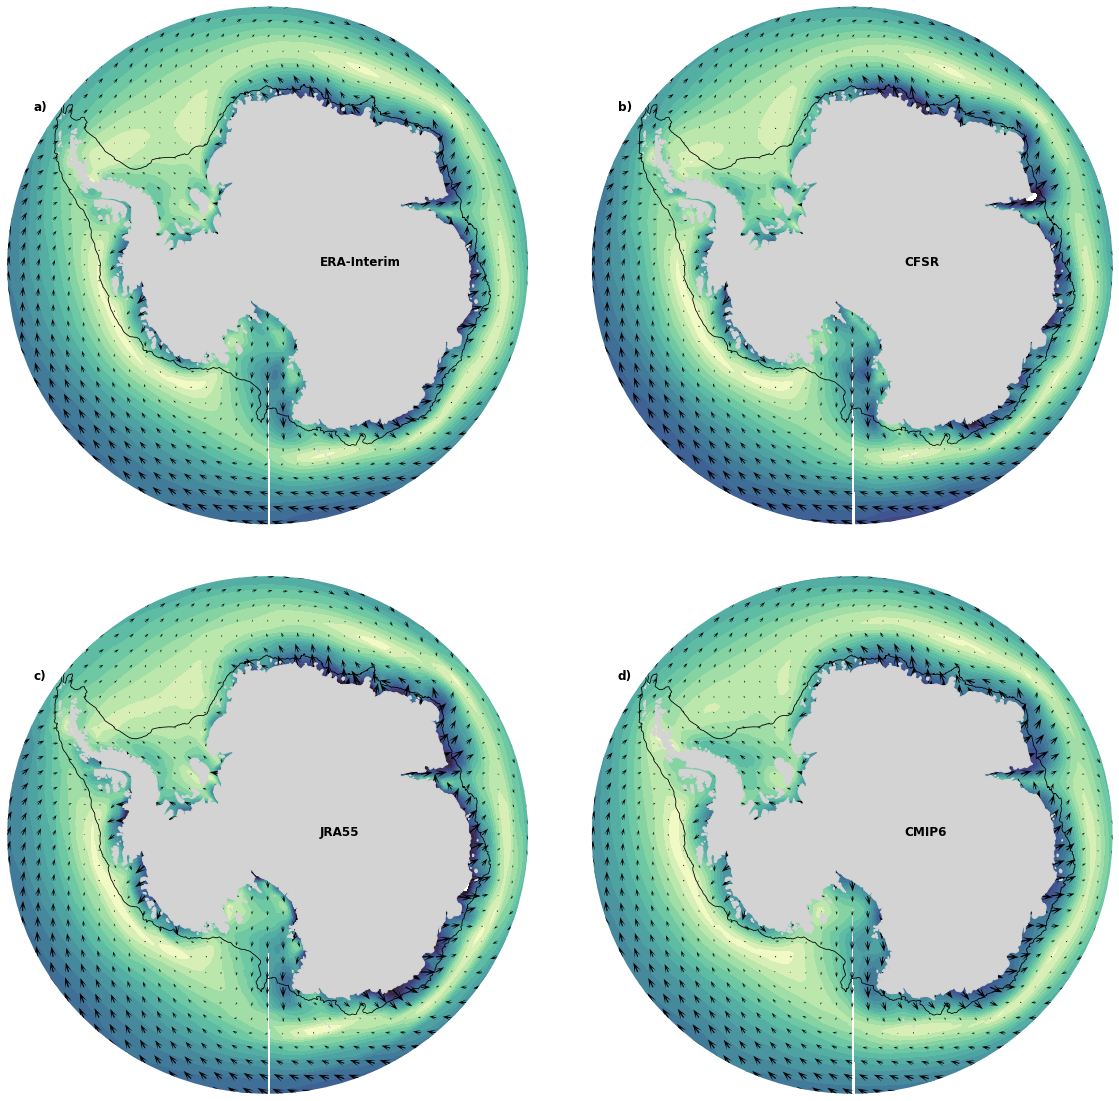

In [69]:
fig = plt.figure(figsize = (20, 20))
gr = gs.GridSpec(2, 2, figure = fig, wspace = 0.1, hspace = 0.1)
axs = [fig.add_subplot(gr[0,0], projection = ccrs.SouthPolarStereo()),
       fig.add_subplot(gr[0,1], projection = ccrs.SouthPolarStereo()),
       fig.add_subplot(gr[1,0], projection = ccrs.SouthPolarStereo()),
       fig.add_subplot(gr[1,1], projection = ccrs.SouthPolarStereo())]
for ax, lb in zip(axs, ['a)', 'b)', 'c)', 'd)']):
    ax.set_extent([-180, 180, -90, -60], ccrs.PlateCarree())
    ax.add_feature(cfeature.NaturalEarthFeature('physical', 'land', '50m', edgecolor = 'lightgrey', facecolor = 'lightgrey'), zorder = 2)
    ax.spines['geo'].set_edgecolor(None)
    ax.text(0.05, .8, lb, transform=ax.transAxes, size = 12, weight='bold')
    ax.patch.set_alpha(0)
    ax.set_boundary(circle, transform = ax.transAxes)
    ax.contourf(land_ice_mask['xu_ocean'], land_ice_mask['yu_ocean'], land_ice_mask, colors = ['lightgrey'], 
                transform = ccrs.PlateCarree())
n = 0
for k, lb in zip(['ERAI', 'CFSR', 'JRA5', 'CMIP'], ['ERA-Interim', 'CFSR', 'JRA55', 'CMIP6']):
    
    u = uas[k].mean('time'); v = vas[k].mean('time')
    
    axs[n].contourf(wsp[k]['lon'], wsp[k]['lat'], wsp[k], levels = np.arange(0, 10.5, .5), cmap = cmocean.cm.deep,
                    transform = ccrs.PlateCarree())
    axs[n].plot(iso['x'], iso['y'], linewidth = 0.8, color = 'k', transform = ccrs.PlateCarree())
    axs[n].quiver(u['lon'].values, v['lat'].values, u.values, v.values, regrid_shape = 35, 
                  headwidth = 6, headlength = 9, transform = ccrs.PlateCarree())
    axs[n].text(0.6, .5, lb, transform = axs[n].transAxes, size = 12, weight='bold')
    n += 1
plt.tight_layout()
plt.savefig('../results/wind_mean-cfsr-erai-jra55_unmasked.jpg', bbox_inches = 'tight')

# Trends 1979 - 2015

In [24]:
from xarrayMannKendall import *

In [70]:
#uas_trends = {}
#vas_trends = {}
for k in ['JRA5']:#['ERAI', 'CFSR', 'JRA5', 'CMIP']:
    u = uas[k].groupby('time.year').mean('time')
    MK_class = Mann_Kendall_test(u, 'time', coords_name = {'year':'time', 'lat':'y', 'lon':'x'})
    uas_trends[k] = MK_class.compute()
    
    v = vas[k].groupby('time.year').mean('time')
    MK_class = Mann_Kendall_test(v, 'time', coords_name = {'year':'time', 'lat':'y', 'lon':'x'})
    vas_trends[k] = MK_class.compute()

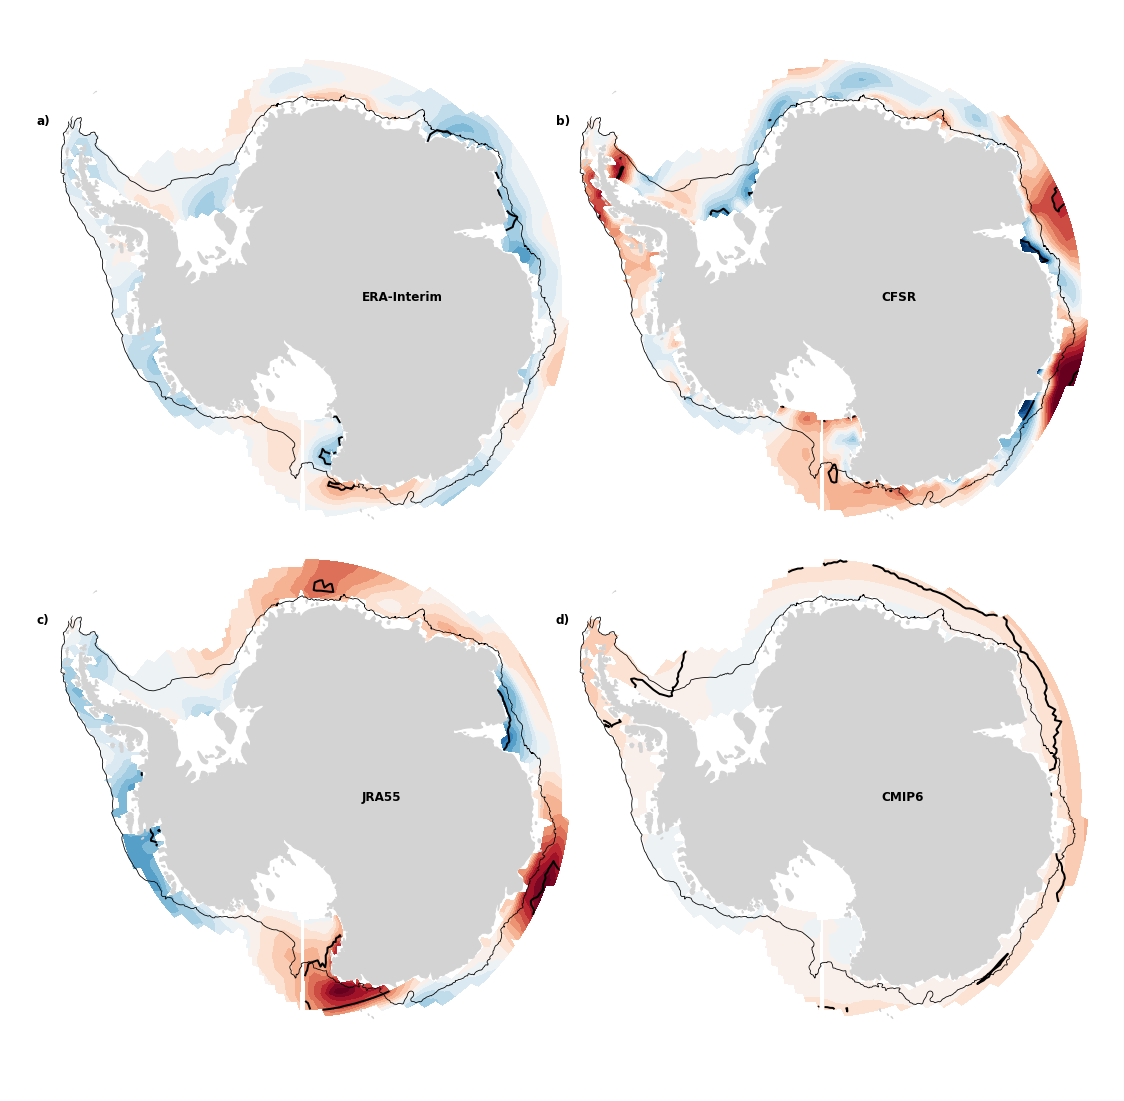

In [71]:
fig = plt.figure(figsize = (20, 20))
gr = gs.GridSpec(2, 2, figure = fig, wspace = -0.13, hspace = -0.15)
axs = [fig.add_subplot(gr[0,0], projection = ccrs.SouthPolarStereo()),
       fig.add_subplot(gr[0,1], projection = ccrs.SouthPolarStereo()),
       fig.add_subplot(gr[1,0], projection = ccrs.SouthPolarStereo()),
       fig.add_subplot(gr[1,1], projection = ccrs.SouthPolarStereo())]
for ax, lb in zip(axs, ['a)', 'b)', 'c)', 'd)']):
    ax.set_extent([-180, 180, -90, -60], ccrs.PlateCarree())
    ax.add_feature(cfeature.NaturalEarthFeature('physical', 'land', '50m', edgecolor = 'lightgrey', facecolor = 'lightgrey'), zorder = 2)
    ax.spines['geo'].set_edgecolor(None)
    ax.text(0.05, .8, lb, transform=ax.transAxes, size = 12, weight='bold')
    ax.patch.set_alpha(0)
    ax.set_boundary(circle, transform = ax.transAxes)
n = 0
for k, lb in zip(['ERAI', 'CFSR', 'JRA5', 'CMIP'], ['ERA-Interim', 'CFSR', 'JRA55', 'CMIP6']):
    
    u = uas_trends[k].rename({'x':'lon', 'y':'lat'})
    
    axs[n].contourf(u['lon'], u['lat'], u['trend']*10*mask, levels = np.arange(-.5, .55, .05), cmap = 'RdBu_r', extend = 'both',
                    transform = ccrs.PlateCarree())
    axs[n].contour(u['lon'], u['lat'], u['p']*10*mask, levels = [0.05], colors = ['k'], linewidths = [2], transform = ccrs.PlateCarree())
    axs[n].plot(iso['x'], iso['y'], linewidth = 0.8, color = 'k', transform = ccrs.PlateCarree())
    axs[n].text(0.6, .5, lb, transform = axs[n].transAxes, size = 12, weight='bold')
    n += 1
plt.tight_layout()
plt.savefig('../results/uas_trends-historical-cfsr-erai-jra55.jpg', bbox_inches = 'tight')

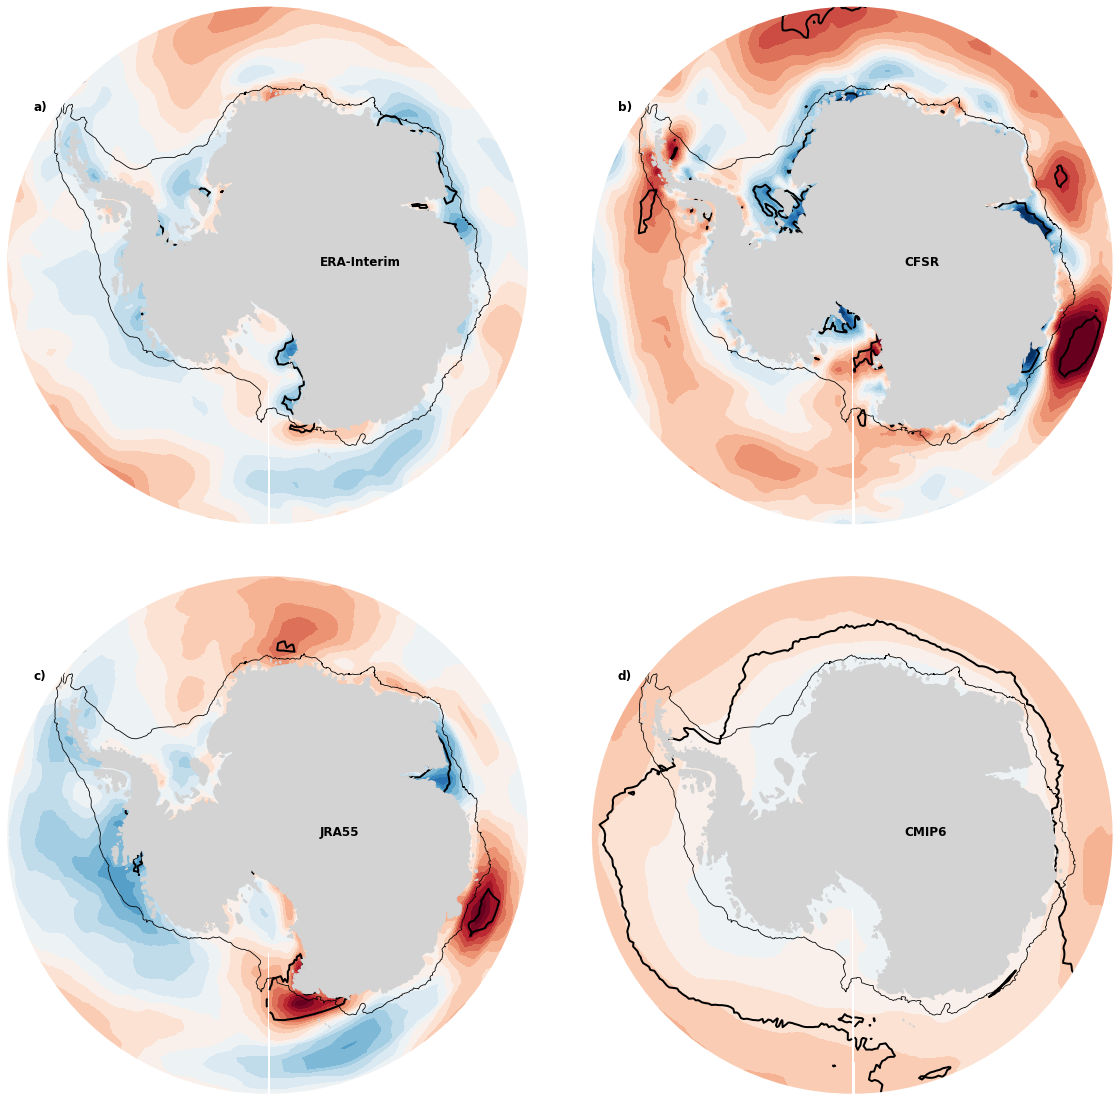

In [72]:
fig = plt.figure(figsize = (20, 20))
gr = gs.GridSpec(2, 2, figure = fig, wspace = 0.1, hspace = 0.1)
axs = [fig.add_subplot(gr[0,0], projection = ccrs.SouthPolarStereo()),
       fig.add_subplot(gr[0,1], projection = ccrs.SouthPolarStereo()),
       fig.add_subplot(gr[1,0], projection = ccrs.SouthPolarStereo()),
       fig.add_subplot(gr[1,1], projection = ccrs.SouthPolarStereo())]
for ax, lb in zip(axs, ['a)', 'b)', 'c)', 'd)']):
    ax.set_extent([-180, 180, -90, -60], ccrs.PlateCarree())
    ax.add_feature(cfeature.NaturalEarthFeature('physical', 'land', '50m', edgecolor = 'lightgrey', facecolor = 'lightgrey'), zorder = 2)
    ax.spines['geo'].set_edgecolor(None)
    ax.text(0.05, .8, lb, transform=ax.transAxes, size = 12, weight='bold')
    ax.patch.set_alpha(0)
    ax.set_boundary(circle, transform = ax.transAxes)
n = 0
for k, lb in zip(['ERAI', 'CFSR', 'JRA5', 'CMIP'], ['ERA-Interim', 'CFSR', 'JRA55', 'CMIP6']):
    
    u = uas_trends[k].rename({'x':'lon', 'y':'lat'})
    
    axs[n].contourf(u['lon'], u['lat'], u['trend']*10, levels = np.arange(-.5, .55, .05), cmap = 'RdBu_r', extend = 'both',
                    transform = ccrs.PlateCarree())
    axs[n].contour(u['lon'], u['lat'], u['p']*10, levels = [0.05], colors = ['k'], linewidths = [2], transform = ccrs.PlateCarree())
    axs[n].plot(iso['x'], iso['y'], linewidth = 0.8, color = 'k', transform = ccrs.PlateCarree())
    axs[n].text(0.6, .5, lb, transform = axs[n].transAxes, size = 12, weight='bold')
    n += 1
plt.tight_layout()
plt.savefig('../results/uas_trends-historical-cfsr-erai-jra55_unmasked.jpg', bbox_inches = 'tight')

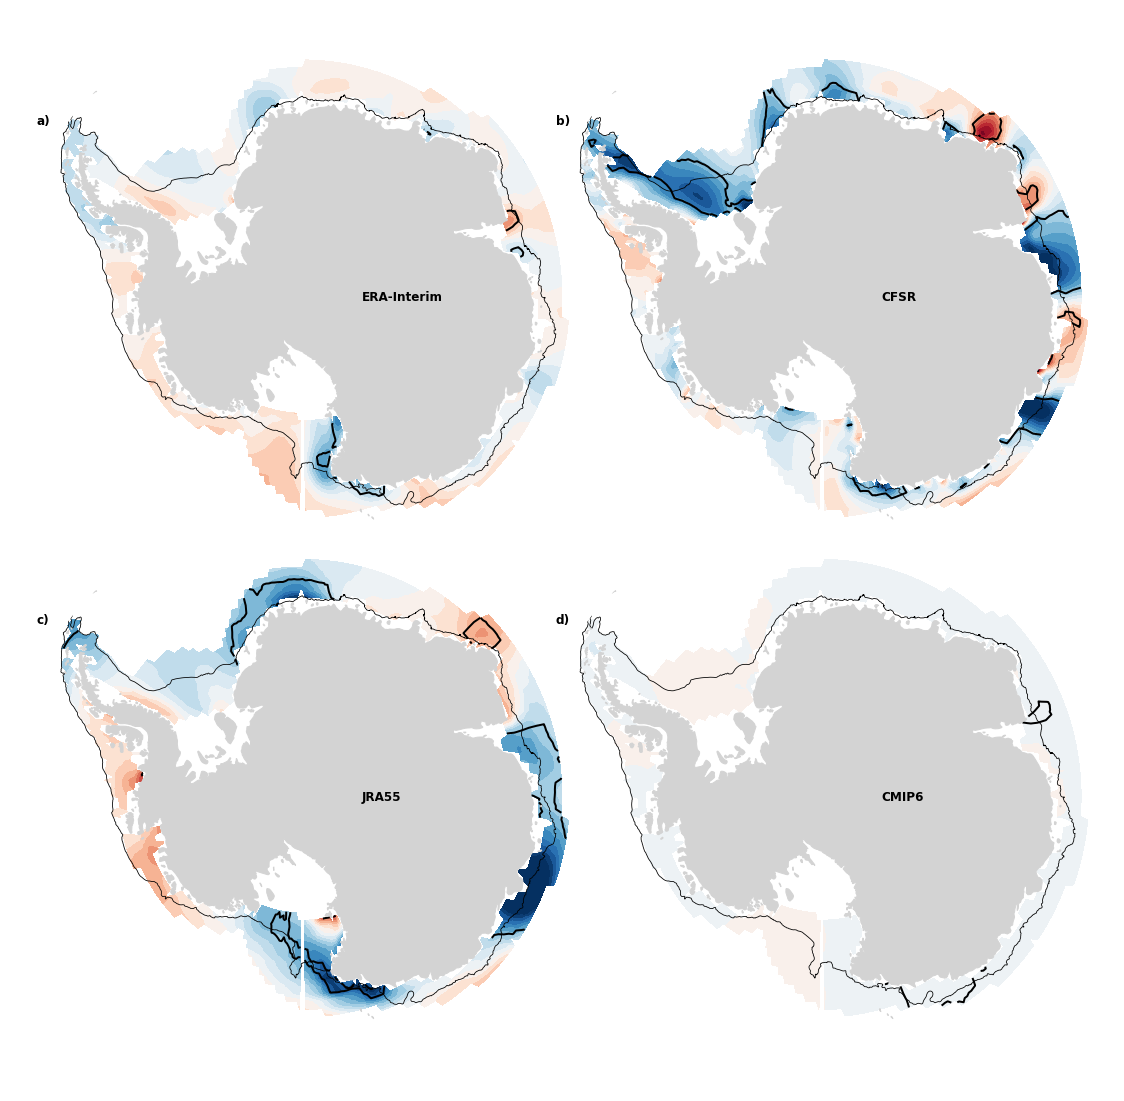

In [73]:
fig = plt.figure(figsize = (20, 20))
gr = gs.GridSpec(2, 2, figure = fig, wspace = -0.13, hspace = -0.15)
axs = [fig.add_subplot(gr[0,0], projection = ccrs.SouthPolarStereo()),
       fig.add_subplot(gr[0,1], projection = ccrs.SouthPolarStereo()),
       fig.add_subplot(gr[1,0], projection = ccrs.SouthPolarStereo()),
       fig.add_subplot(gr[1,1], projection = ccrs.SouthPolarStereo())]
for ax, lb in zip(axs, ['a)', 'b)', 'c)', 'd)']):
    ax.set_extent([-180, 180, -90, -60], ccrs.PlateCarree())
    ax.add_feature(cfeature.NaturalEarthFeature('physical', 'land', '50m', edgecolor = 'lightgrey', facecolor = 'lightgrey'), zorder = 2)
    ax.spines['geo'].set_edgecolor(None)
    ax.text(0.05, .8, lb, transform=ax.transAxes, size = 12, weight='bold')
    ax.patch.set_alpha(0)
    ax.set_boundary(circle, transform = ax.transAxes)
n = 0
for k, lb in zip(['ERAI', 'CFSR', 'JRA5', 'CMIP'], ['ERA-Interim', 'CFSR', 'JRA55', 'CMIP6']):
    
    u = vas_trends[k].rename({'x':'lon', 'y':'lat'})
    
    axs[n].contourf(u['lon'], u['lat'], u['trend']*10*mask, levels = np.arange(-.5, .55, .05), cmap = 'RdBu_r', extend = 'both',
                    transform = ccrs.PlateCarree())
    axs[n].contour(u['lon'], u['lat'], u['p']*10*mask, levels = [0.05], colors = ['k'], linewidths = [2], transform = ccrs.PlateCarree())
    axs[n].plot(iso['x'], iso['y'], linewidth = 0.8, color = 'k', transform = ccrs.PlateCarree())
    axs[n].text(0.6, .5, lb, transform = axs[n].transAxes, size = 12, weight='bold')
    n += 1
plt.tight_layout()
plt.savefig('../results/vas_trends-historical-cfsr-erai-jra55.jpg', bbox_inches = 'tight')

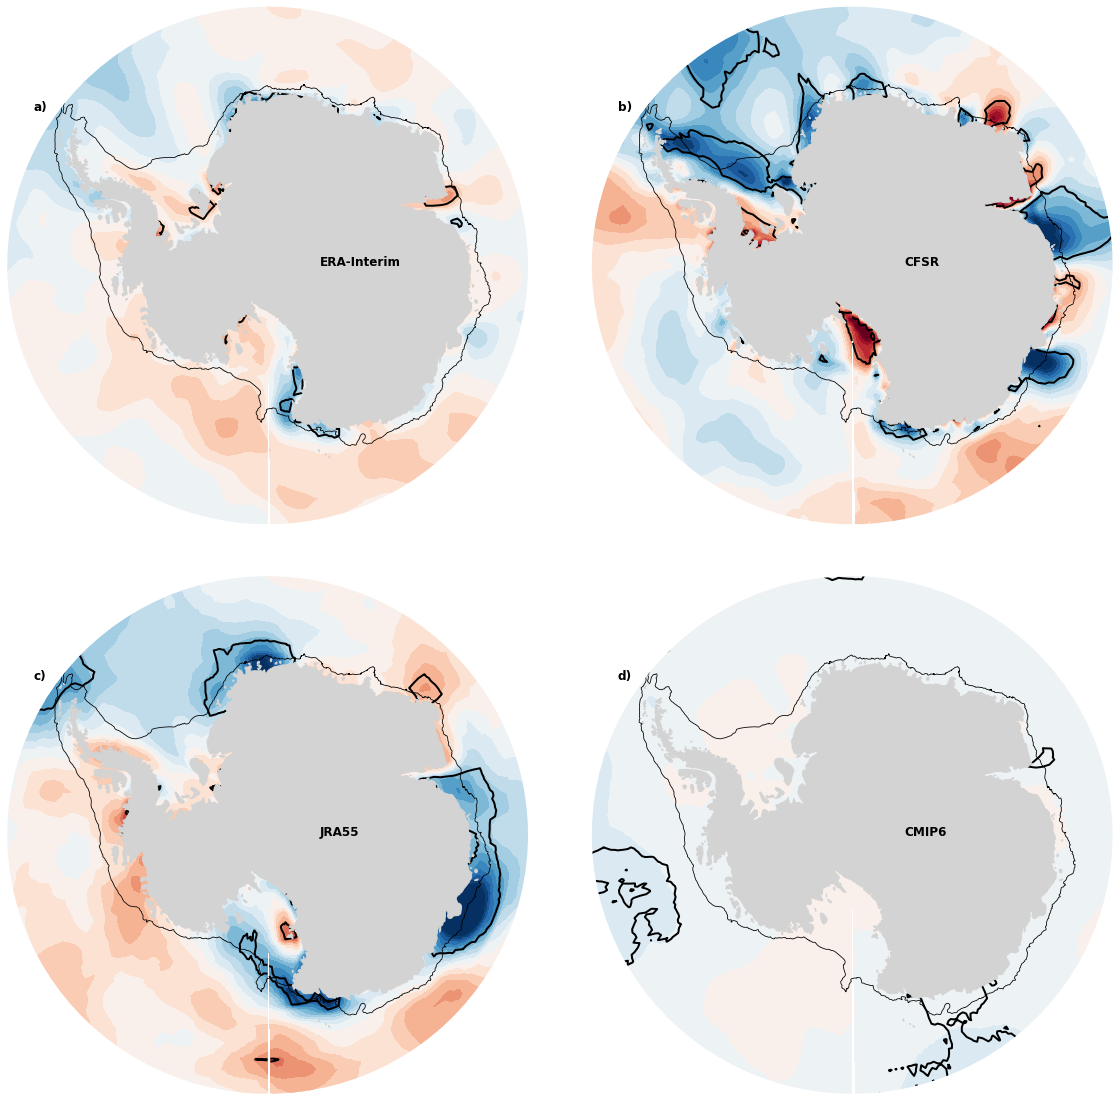

In [74]:
fig = plt.figure(figsize = (20, 20))
gr = gs.GridSpec(2, 2, figure = fig, wspace = 0.1, hspace = 0.1)
axs = [fig.add_subplot(gr[0,0], projection = ccrs.SouthPolarStereo()),
       fig.add_subplot(gr[0,1], projection = ccrs.SouthPolarStereo()),
       fig.add_subplot(gr[1,0], projection = ccrs.SouthPolarStereo()),
       fig.add_subplot(gr[1,1], projection = ccrs.SouthPolarStereo())]
for ax, lb in zip(axs, ['a)', 'b)', 'c)', 'd)']):
    ax.set_extent([-180, 180, -90, -60], ccrs.PlateCarree())
    ax.add_feature(cfeature.NaturalEarthFeature('physical', 'land', '50m', edgecolor = 'lightgrey', facecolor = 'lightgrey'), zorder = 2)
    ax.spines['geo'].set_edgecolor(None)
    ax.text(0.05, .8, lb, transform=ax.transAxes, size = 12, weight='bold')
    ax.patch.set_alpha(0)
    ax.set_boundary(circle, transform = ax.transAxes)
n = 0
for k, lb in zip(['ERAI', 'CFSR', 'JRA5', 'CMIP'], ['ERA-Interim', 'CFSR', 'JRA55', 'CMIP6']):
    
    u = vas_trends[k].rename({'x':'lon', 'y':'lat'})
    
    axs[n].contourf(u['lon'], u['lat'], u['trend']*10, levels = np.arange(-.5, .55, .05), cmap = 'RdBu_r', extend = 'both',
                    transform = ccrs.PlateCarree())
    axs[n].contour(u['lon'], u['lat'], u['p']*10, levels = [0.05], colors = ['k'], linewidths = [2], transform = ccrs.PlateCarree())
    axs[n].plot(iso['x'], iso['y'], linewidth = 0.8, color = 'k', transform = ccrs.PlateCarree())
    axs[n].text(0.6, .5, lb, transform = axs[n].transAxes, size = 12, weight='bold')
    n += 1
plt.tight_layout()
plt.savefig('../results/vas_trends-historical-cfsr-erai-jra55_unmasked.jpg', bbox_inches = 'tight')

# Average per longitude

In [75]:
u_ave = {}
v_ave = {}
for k in ['ERAI', 'CFSR', 'JRA5', 'CMIP']:
    u_ave[k] = (uas[k].mean('time')*mask).mean('lat')
    v_ave[k] = (vas[k].mean('time')*mask).mean('lat')

In [76]:
u_ave_t = {}
v_ave_t = {}
for k in ['ERAI', 'CFSR', 'JRA5', 'CMIP']:
    u_ave_t[k] = (uas_trends[k]['trend'].rename({'x':'lon', 'y':'lat'})*mask).mean('lat')
    v_ave_t[k] = (vas_trends[k]['trend'].rename({'x':'lon', 'y':'lat'})*mask).mean('lat')

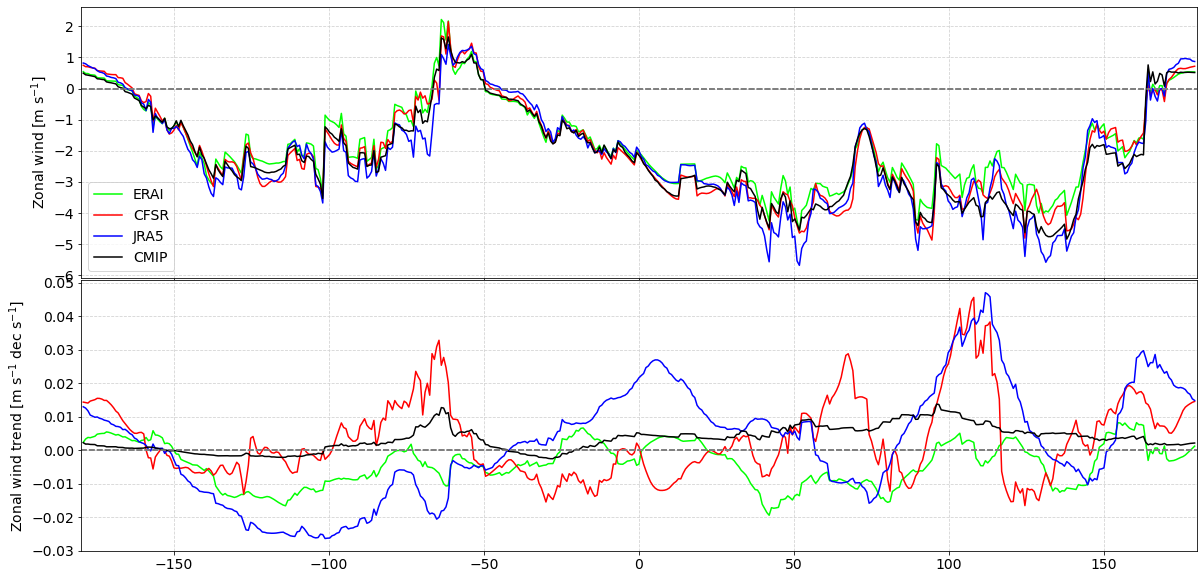

In [77]:
plt.rcParams['font.size'] = 14
fig = plt.figure(figsize = (20,10))
ax1 = plt.subplot(211)
ax1.set_xlim(-180, 180)
ax2 = plt.subplot(212, sharex = ax1)
fig.subplots_adjust(hspace = 0.01)
for k, c in zip(['ERAI', 'CFSR', 'JRA5', 'CMIP'], ['lime', 'r', 'b', 'k']):
    ax1.plot(u_ave[k]['lon'], u_ave[k], color = c, label = k)
    ax2.plot(u_ave_t[k]['lon'], u_ave_t[k], color = c)
    ax1.grid(linestyle = '--', color = 'lightgrey')
    ax2.grid(linestyle = '--', color = 'lightgrey')
    ax1.axhline(y = 0, linestyle = '--', color = 'grey')
    ax2.axhline(y = 0, linestyle = '--', color = 'grey')
    ax1.set_ylabel('Zonal wind [m s$^{-1}$]')
    ax2.set_ylabel('Zonal wind trend [m s$^{-1}$ dec s$^{-1}$]')
ax1.legend()
plt.savefig('../results/uas_ave_trends-historical-cfsr-erai-jra55.jpg', bbox_inches = 'tight')

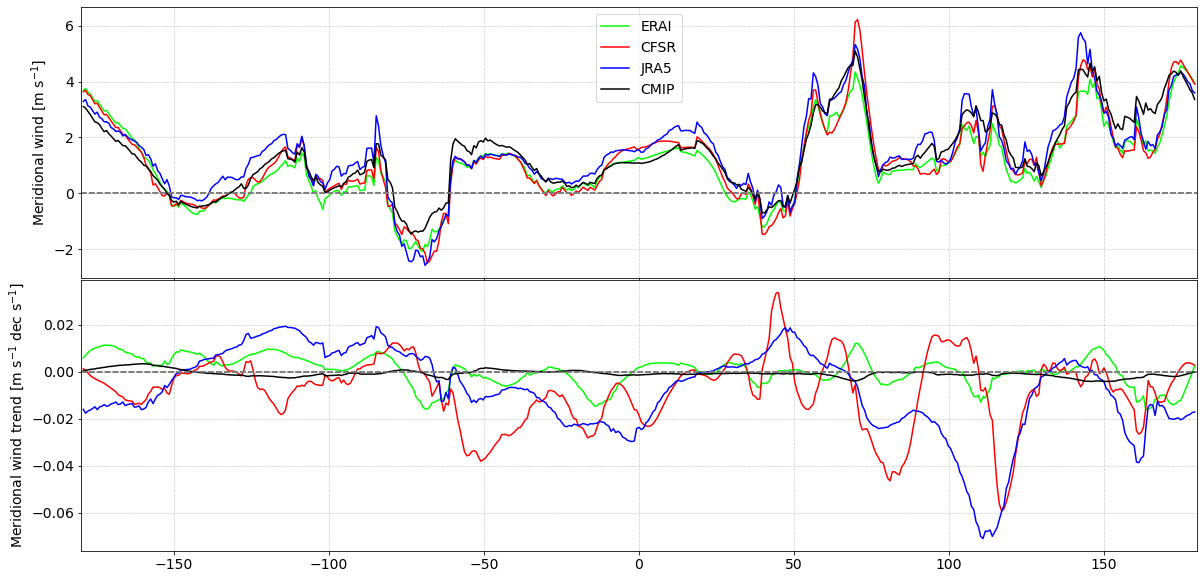

In [78]:
plt.rcParams['font.size'] = 14
fig = plt.figure(figsize = (20,10))
ax1 = plt.subplot(211)
ax1.set_xlim(-180, 180)
ax2 = plt.subplot(212, sharex = ax1)
fig.subplots_adjust(hspace = 0.01)
for k, c in zip(['ERAI', 'CFSR', 'JRA5', 'CMIP'], ['lime', 'r', 'b', 'k']):
    ax1.plot(v_ave[k]['lon'], v_ave[k], color = c, label = k)
    ax2.plot(v_ave_t[k]['lon'], v_ave_t[k], color = c)
    ax1.grid(linestyle = '--', color = 'lightgrey')
    ax2.grid(linestyle = '--', color = 'lightgrey')
    ax1.axhline(y = 0, linestyle = '--', color = 'grey')
    ax2.axhline(y = 0, linestyle = '--', color = 'grey')
    ax1.set_ylabel('Meridional wind [m s$^{-1}$]')
    ax2.set_ylabel('Meridional wind trend [m s$^{-1}$ dec s$^{-1}$]')
ax1.legend()
plt.savefig('../results/vas_ave_trends-historical-cfsr-erai-jra55.jpg', bbox_inches = 'tight')

# Time series of averages with CMIP6 proj

In [46]:
import glob

In [79]:
uas_cmip = {}; vas_cmip = {}
# CMIP6 individual models
path_uas = glob.glob('../data/cmip6-regridded/uas_hist*')
path_vas = glob.glob('../data/cmip6-regridded/vas_hist*')
for i in range(len(path_uas)):
    model_name = path_uas[i].split('/')[-1].split('_')[-1].split('.')[0]
    uas_cmip[model_name] = xr.open_dataset(path_uas[i])['uas'].sel(time = slice('1979-01-01', '2015-01-01'))
    
    model_name = path_vas[i].split('/')[-1].split('_')[-1].split('.')[0]
    vas_cmip[model_name] = xr.open_dataset(path_vas[i])['vas'].sel(time = slice('1979-01-01', '2015-01-01'))
model_names = list(uas_cmip.keys())

In [80]:
u_hist = {}
v_hist = {}
for n in model_names:
    u_hist[n] = (uas_cmip[n]*mask).groupby('time.year').mean('time').mean(['lat', 'lon'])
    v_hist[n] = (vas_cmip[n]*mask).groupby('time.year').mean('time').mean(['lat', 'lon'])

In [82]:
u_sd_h = u_hist[model_names[0]]
v_sd_h = v_hist[model_names[0]]
for n in model_names[1:]:
    u_sd_h = xr.concat([u_sd_h, u_hist[n]], dim = 'model')
    v_sd_h = xr.concat([v_sd_h, v_hist[n]], dim = 'model')
u_sd_h = u_sd_h.std('model')
v_sd_h = v_sd_h.std('model')

In [81]:
for k in ['ERAI', 'CFSR', 'JRA5', 'CMIP']:
    u_hist[k] = (uas[k]*mask).groupby('time.year').mean('time').mean(['lat', 'lon'])
    v_hist[k] = (vas[k]*mask).groupby('time.year').mean('time').mean(['lat', 'lon'])

In [108]:
uas_cmip_proj = {}; vas_cmip_proj = {}
uas_cmip_proj['CMIP'] = xr.open_dataset('../data/uas-cmip6-monthly-2015_2100-ssp85.nc')
vas_cmip_proj['CMIP'] = xr.open_dataset('../data/vas-cmip6-monthly-2015_2100-ssp85.nc')
# CMIP6 individual models
path_uas = glob.glob('../data/cmip6-regridded/uas_ssp*')
path_vas = glob.glob('../data/cmip6-regridded/vas_ssp*')
for i in range(len(path_uas)):
    model_name = path_uas[i].split('/')[-1].split('_')[-1].split('.')[0][5:]
    uas_cmip_proj[model_name] = xr.open_dataset(path_uas[i])['uas']
    
    model_name = path_vas[i].split('/')[-1].split('_')[-1].split('.')[0][5:]
    vas_cmip_proj[model_name] = xr.open_dataset(path_vas[i])['vas']
model_names = list(uas_cmip_proj.keys())

In [109]:
u_proj = {}
v_proj = {}
for n in model_names:
    u_proj[n] = (uas_cmip_proj[n]*mask).groupby('time.year').mean('time').mean(['lat', 'lon'])
    v_proj[n] = (vas_cmip_proj[n]*mask).groupby('time.year').mean('time').mean(['lat', 'lon'])

In [82]:
u_sd_h = u_hist[model_names[0]]
v_sd_h = v_hist[model_names[0]]
for n in model_names[1:]:
    u_sd_h = xr.concat([u_sd_h, u_hist[n]], dim = 'model')
    v_sd_h = xr.concat([v_sd_h, v_hist[n]], dim = 'model')
u_sd_h = u_sd_h.std('model')
v_sd_h = v_sd_h.std('model')

In [97]:
u_sd_p = u_proj[model_names[1]]
v_sd_p = v_proj[model_names[1]]
for n in model_names[2:]:
    u_sd_p = xr.concat([u_sd_p, u_proj[n]], dim = 'model')
    v_sd_p = xr.concat([v_sd_p, v_proj[n]], dim = 'model')
u_sd_p = u_sd_p.std('model')
v_sd_p = v_sd_p.std('model')

In [103]:
u_cmip_complete = xr.concat([u_hist['CMIP'], u_proj['CMIP']['uas']], dim = 'year')

In [115]:
u_sd = xr.concat([u_hist[model_names[1]], u_proj[model_names[1]]], dim = 'year')
v_sd = xr.concat([v_hist[model_names[1]], v_proj[model_names[1]]], dim = 'year')
for n in model_names[2:]:
    u_sd = xr.concat([u_sd, xr.concat([u_hist[n], u_proj[n]], dim = 'year')], dim = 'model')
    v_sd = xr.concat([v_sd, xr.concat([v_hist[n], v_proj[n]], dim = 'year')], dim = 'model')
u_sd = u_sd.std('model')
v_sd = v_sd.std('model')

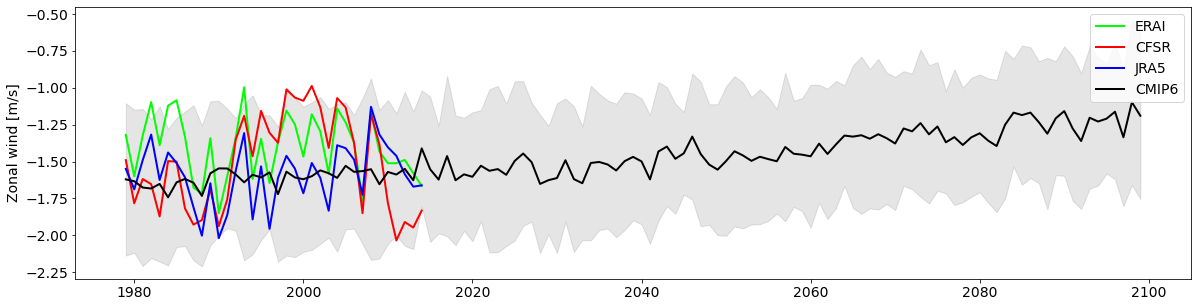

In [121]:
plt.figure(figsize = (20,5))
for k, c in zip(['ERAI', 'CFSR', 'JRA5'], ['lime', 'r', 'b']):
    plt.plot(u_hist[k]['year'], u_hist[k], color = c, linewidth = 2, label = k)
#plt.fill_between(u_cmip_complete['CMIP']['year'], u_cmip_complete-u_sd_h, u_hist['CMIP']+u_sd_h, color = 'k', alpha = 0.1)
plt.plot(u_cmip_complete['year'], u_cmip_complete, color = 'k', linewidth = 2, label = 'CMIP6')
plt.fill_between(u_cmip_complete['year'], u_cmip_complete-u_sd, u_cmip_complete+u_sd, color = 'k', alpha = 0.1)
plt.ylabel('Zonal wind [m/s]')
plt.legend()
plt.savefig('../results/uas_hist_proj.jpg', bbox_inches = 'tight')

In [117]:
v_cmip_complete = xr.concat([v_hist['CMIP'], v_proj['CMIP']['vas']], dim = 'year')

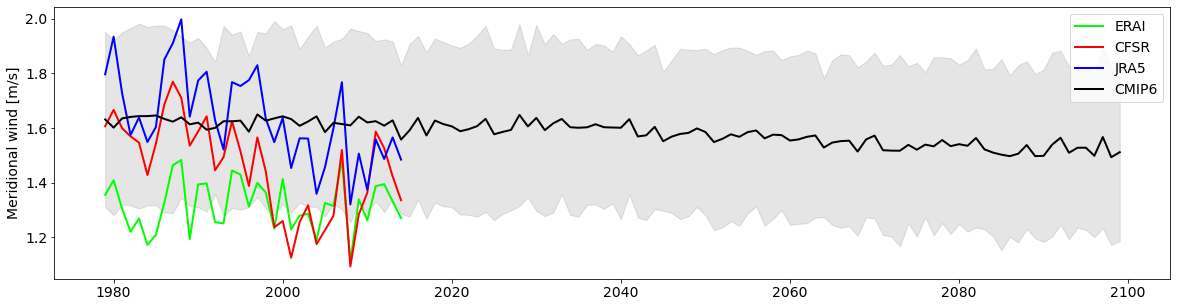

In [122]:
plt.figure(figsize = (20,5))
for k, c in zip(['ERAI', 'CFSR', 'JRA5'], ['lime', 'r', 'b']):
    plt.plot(v_hist[k]['year'], v_hist[k], color = c, linewidth = 2, label = k)
#plt.fill_between(u_cmip_complete['CMIP']['year'], u_cmip_complete-u_sd_h, u_hist['CMIP']+u_sd_h, color = 'k', alpha = 0.1)
plt.plot(v_cmip_complete['year'], v_cmip_complete, color = 'k', linewidth = 2, label = 'CMIP6')
plt.fill_between(v_cmip_complete['year'], v_cmip_complete-v_sd, v_cmip_complete+v_sd, color = 'k', alpha = 0.1)
plt.ylabel('Meridional wind [m/s]')
plt.legend()
plt.savefig('../results/vas_hist_proj.jpg', bbox_inches = 'tight')